## Perguntas

1) Correlação das variaveis
2) Qual estilo de jogo é mais provavel de se ter melhores vendas? (Predição)
3) Qual plataforma é provavel de se ter melhores vendas? (Predição)
4)  Aplicar um modelo de regressão ou classificação utilizando uma técnica de hiperparametrização automática;</br>
5)  Aplicar uma medida de avaliação do modelo.
6)  Agrupamento: gerar a visualização Scatter
7)  Classificação: gerar a matriz de confusão
8)  Regressão: gerar a visualização da linha de saída

#### Consoles para analise

Wii     PS3     XBox360
WiiU    PS4     XOne

### Leitura dos dados

In [1]:
# Somente rodar se necessário
# Descomente a linha a baixo para rodar!

# %pip install googletrans==4.0.0-rc1

In [2]:
#IMPORT E INSTALL AS BIBLIOTECAS IMPORTANTES
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
from googletrans import Translator # Precisa do pacote do pip install
import time

In [3]:
caminho = 'Data/vgchartz-2024.csv'
jogos = pd.read_csv(caminho)

### Tratamento dos dados

In [4]:
# Drop das colunas que não seram usados em nenhuma análise
jogos_tratados = jogos.drop(columns=['img','last_update'])
jogos_tratados.head(3)

,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date
0,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17
1,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18
2,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28


#### Tradução dos index das colunas e da coluna Gênero de jogo

In [5]:
def traduzir_colunas(df, language='pt'):

    # Função para traduzir uma lista de gêneros
    def traduzir_generos(generos, language='pt'):
        tradutor = Translator()
        traducoes = {}
        
        falha_ao_traduzir = {
            'shooter': 'Jogos de Tiro'
        }

        for genero in generos:
            try:
                genero_minusculo = genero.lower()
                if genero_minusculo in falha_ao_traduzir:
                    traducoes[genero] = falha_ao_traduzir[genero_minusculo].capitalize() # Utilize a tradução personalizada
                else:
                    traduzido = tradutor.translate(genero, src='en', dest=language)
                    if traduzido and traduzido.text:
                        capslock = traduzido.text.capitalize()  # Maiúscula na primeira letra de cada palavra
                        traducoes[genero] = capslock
                        #print(f"'{genero}' traduzido para '{capslock}'")  # Debug: Mostrar a tradução
                    else:
                        print(f"Erro ao traduzir o genero '{genero}': tradução retornou None ou texto vazio")
                        traducoes[genero] = genero  # Manter o nome original em caso de erro
            except Exception as e:
                print(f"Erro ao traduzir o genero '{genero}': {e}")
                traducoes[genero] = genero  # Manter o nome original em caso de erro

        return traducoes
    
    # Renomear as colunas
    traducoes = {}
    falha_ao_traduzir = {
        'publisher': 'Editora',
        'developer': 'Desenvolvedora',
        'na_sales': 'Vendas_na',
        'jp_sales': 'Vendas_jp',
        'pal_sales': 'Vendas_pal',
        'other_sales': 'Vendas_demais_regiões',
        'critic_score': 'Pontuação_Geral'
    }
    tradutor = Translator()  # Correção aqui
    for coluna in df.columns:
        try:
            coluna_minuscula = coluna.lower()
            if coluna_minuscula in falha_ao_traduzir:
                traducoes[coluna] = falha_ao_traduzir[coluna_minuscula].capitalize()  # Utilize a tradução personalizada
            else:
                traduzido = tradutor.translate(coluna, src='en', dest=language)  # Correção aqui
                if traduzido and traduzido.text:
                    capslock = traduzido.text.capitalize()  # Maiuscula na primeira letra de cada palavra
                    traducoes[coluna] = capslock
                else:
                    print(f"Erro ao traduzir a coluna '{coluna}': tradução retornou None ou texto vazio")
                    traducoes[coluna] = coluna  # Manter o nome original em caso de erro
        except Exception as e:
            print(f"Erro ao traduzir a coluna '{coluna}': {e}")
            traducoes[coluna] = coluna  # Manter o nome original em caso de erro
    
    df.columns = [traducoes.get(col, col) for col in df.columns]
    
    # Traduzir a coluna 'Gênero'
    if 'Gênero' in df.columns:
        generos = df['Gênero'].unique()
        genero_traduzido = traduzir_generos(generos, language)
        df['Gênero'] = df['Gênero'].map(genero_traduzido)

In [6]:
#EXECUTA A FUNÇÃO DE TRADUÇÃO
traduzir_colunas(jogos_tratados)
jogos_tratados.head(5)

,Título,Console,Gênero,Editora,Desenvolvedora,Pontuação_geral,Vendas totais,Vendas_na,Vendas_jp,Vendas_pal,Vendas_demais_regiões,Data de lançamento
0,Grand Theft Auto V,PS3,Ação,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17
1,Grand Theft Auto V,PS4,Ação,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18
2,Grand Theft Auto: Vice City,PS2,Ação,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28
3,Grand Theft Auto V,X360,Ação,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17
4,Call of Duty: Black Ops 3,PS4,Jogos de tiro,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06


In [7]:
# Contagem dos valores zerados em toda a base
jogos_tratados.isna().sum()

Título                       0
Console                      0
Gênero                       0
Editora                      0
Desenvolvedora              17
Pontuação_geral          57338
Vendas totais            45094
Vendas_na                51379
Vendas_jp                57290
Vendas_pal               51192
Vendas_demais_regiões    48888
Data de lançamento        7051
dtype: int64

In [8]:
# Separação dos consoles que pretendemos trabalhar
consoles = ('PS3','PS4','X360','XOne','Wii','WiiU')
jogos_tratados = jogos_tratados[(jogos_tratados['Console'].isin(consoles))]
jogos_tratados.reset_index()
jogos_tratados.head(3)


,Título,Console,Gênero,Editora,Desenvolvedora,Pontuação_geral,Vendas totais,Vendas_na,Vendas_jp,Vendas_pal,Vendas_demais_regiões,Data de lançamento
0,Grand Theft Auto V,PS3,Ação,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17
1,Grand Theft Auto V,PS4,Ação,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18
3,Grand Theft Auto V,X360,Ação,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17


In [9]:
# Visualização das infos tratadas
jogos_tratados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10711 entries, 0 to 64015
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Título                 10711 non-null  object 
 1   Console                10711 non-null  object 
 2   Gênero                 10711 non-null  object 
 3   Editora                10711 non-null  object 
 4   Desenvolvedora         10709 non-null  object 
 5   Pontuação_geral        1802 non-null   float64
 6   Vendas totais          5587 non-null   float64
 7   Vendas_na              4493 non-null   float64
 8   Vendas_jp              1974 non-null   float64
 9   Vendas_pal             3926 non-null   float64
 10  Vendas_demais_regiões  4946 non-null   float64
 11  Data de lançamento     8795 non-null   object 
dtypes: float64(6), object(6)
memory usage: 1.1+ MB


In [10]:
# Visualização das infos tratadas
jogos_tratados.groupby(['Console'])['Console'].count()

Console
PS3     1905
PS4     2878
Wii     1676
WiiU     554
X360    1735
XOne    1963
Name: Console, dtype: int64

In [11]:
# Visualização dos valores zerados em cada categoria na seleção de consoles escolhidas 
jogos_NA = jogos_tratados.groupby('Console').apply(lambda x: x.isna().sum())
jogos_NA

,Título,Console,Gênero,Editora,Desenvolvedora,Pontuação_geral,Vendas totais,Vendas_na,Vendas_jp,Vendas_pal,Vendas_demais_regiões,Data de lançamento
Console,,,,,,,,,,,,
PS3,0,0,0,0,0,1390,557,938,1195,923,813,166
PS4,0,0,0,0,0,2730,1970,2191,2398,2396,2120,776
Wii,0,0,0,0,2,1329,319,561,1421,741,440,83
WiiU,0,0,0,0,0,473,406,442,501,433,421,135
X360,0,0,0,0,0,1096,433,615,1288,665,531,139
XOne,0,0,0,0,0,1891,1439,1471,1934,1627,1440,617


#### Junção dos Consoles em grupos

In [12]:
# Agrupamento dos consoles
mapping = {
    'X360': 'Xbox',
    'XOne': 'Xbox',
    'Wii': 'Nintendo',
    'WiiU': 'Nintendo',
    'PS3': 'Playstation',
    'PS4': 'Playstation'
}

df_jogos = jogos_tratados
df_jogos['Console'] = jogos_tratados['Console'].map(mapping)
df_jogos.groupby(['Console'])['Console'].count()

Console
Nintendo       2230
Playstation    4783
Xbox           3698
Name: Console, dtype: int64

In [13]:
df_jogos.head()

,Título,Console,Gênero,Editora,Desenvolvedora,Pontuação_geral,Vendas totais,Vendas_na,Vendas_jp,Vendas_pal,Vendas_demais_regiões,Data de lançamento
0,Grand Theft Auto V,Playstation,Ação,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17
1,Grand Theft Auto V,Playstation,Ação,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18
3,Grand Theft Auto V,Xbox,Ação,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17
4,Call of Duty: Black Ops 3,Playstation,Jogos de tiro,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06
5,Call of Duty: Modern Warfare 3,Xbox,Jogos de tiro,Activision,Infinity Ward,8.7,14.82,9.07,0.13,4.29,1.33,2011-11-08


#### One hot encoding consoles

##### Transforma a coluna 'Console' em valores numéricos

In [14]:
# Criação do OneHotEncoder
ohe = OneHotEncoder(sparse=False)
encoded = ohe.fit_transform(df_jogos[['Console']])

c:\Users\marce\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
# Criar um novo dataframe com os dados codificados
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(['Console']))

In [16]:
# Concatenar com o dataframe original (excluindo a coluna original 'Console')
ohe_jogos = pd.concat([df_jogos.drop(columns=['Console']), encoded_df], axis=1)

In [19]:
# Exibir o dataframe resultante
ohe_jogos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17668 entries, 0 to 10710
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Título                 10711 non-null  object 
 1   Gênero                 10711 non-null  object 
 2   Editora                10711 non-null  object 
 3   Desenvolvedora         10709 non-null  object 
 4   Pontuação_geral        1802 non-null   float64
 5   Vendas totais          5587 non-null   float64
 6   Vendas_na              4493 non-null   float64
 7   Vendas_jp              1974 non-null   float64
 8   Vendas_pal             3926 non-null   float64
 9   Vendas_demais_regiões  4946 non-null   float64
 10  Data de lançamento     8795 non-null   object 
 11  Console_Nintendo       10711 non-null  float64
 12  Console_Playstation    10711 non-null  float64
 13  Console_Xbox           10711 non-null  float64
dtypes: float64(9), object(5)
memory usage: 2.0+ MB


##### Transforma a coluna 'Gênero' em valores numéricos

In [17]:
# Aplicação do OneHot
encoded2 = ohe.fit_transform(df_jogos[['Gênero']])

c:\Users\marce\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
# Criar um novo dataframe com os dados codificados
encoded_df2 = pd.DataFrame(encoded2, columns=ohe.get_feature_names_out(['Gênero']))

In [21]:
# Concatenar com o dataframe original (excluindo a coluna original 'Gênero')
ohe_jogos = pd.concat([ohe_jogos.drop(columns=['Gênero']), encoded_df2], axis=1)

In [22]:
# Exibir o dataframe resultante
ohe_jogos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17668 entries, 0 to 10710
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Título                          10711 non-null  object 
 1   Editora                         10711 non-null  object 
 2   Desenvolvedora                  10709 non-null  object 
 3   Pontuação_geral                 1802 non-null   float64
 4   Vendas totais                   5587 non-null   float64
 5   Vendas_na                       4493 non-null   float64
 6   Vendas_jp                       1974 non-null   float64
 7   Vendas_pal                      3926 non-null   float64
 8   Vendas_demais_regiões           4946 non-null   float64
 9   Data de lançamento              8795 non-null   object 
 10  Console_Nintendo                10711 non-null  float64
 11  Console_Playstation             10711 non-null  float64
 12  Console_Xbox                    

### Análise de correlação de variáveis

In [23]:
# Drop das colunas de vendas regionais
df_corr = ohe_jogos.drop(columns=['Vendas_na', 'Vendas_jp', 'Vendas_pal','Vendas_demais_regiões'])

In [24]:
df_corr.head()

,Título,Editora,Desenvolvedora,Pontuação_geral,Vendas totais,Data de lançamento,Console_Nintendo,Console_Playstation,Console_Xbox,Gênero_Aventura,...,Gênero_Interpretação de papéis,Gênero_Jogo de tabuleiro,Gênero_Jogos de tiro,Gênero_Misc,Gênero_Mmo,Gênero_Música,Gênero_Plataforma,Gênero_Quebra-cabeça,Gênero_Romance visual,Gênero_Simulação
0,Grand Theft Auto V,Rockstar Games,Rockstar North,9.4,20.32,2013-09-17,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Grand Theft Auto V,Rockstar Games,Rockstar North,9.7,19.39,2014-11-18,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Grand Theft Auto V,Rockstar Games,Rockstar North,NaN,15.86,2013-09-17,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Call of Duty: Black Ops 3,Activision,Treyarch,8.1,15.09,2015-11-06,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Call of Duty: Modern Warfare 3,Activision,Infinity Ward,8.7,14.82,2011-11-08,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df_corr.dropna(subset=['Vendas totais'], inplace=True)
#df_corr

C:\Users\marce\AppData\Local\Temp\ipykernel_17036\3367099422.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_corr.corr(), annot = True)
c:\Users\marce\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

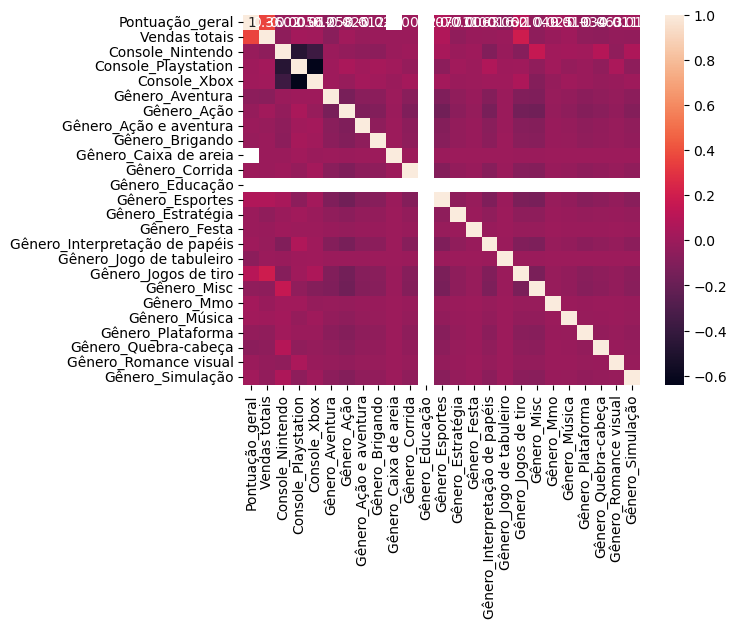

In [29]:
sns.heatmap(df_corr.corr(), annot = True)